#### Import required packages

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import Row
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
import re
import numpy as np
import matplotlib.pyplot as plt

#### Create configs

In [3]:
conf = SparkConf().setMaster("local").setAppName("Project_BigData")
sc = SparkContext.getOrCreate(conf = conf)
sqlcon = SQLContext.getOrCreate(sc)

#### Some global variables

In [4]:
pat1 = re.compile(r'"([a-xA-Z0-9. ,]+), ([a-xA-Z0-9. ,]+)"')
pat2 = re.compile(r'"([,]+)"')
keep = ['CASE_STATUS','EMPLOYER_NAME','EMPLOYER_STATE',\
        'AGENT_REPRESENTING_EMPLOYER','JOB_TITLE','SOC_NAME','NAICS_CODE','TOTAL_WORKERS',\
        'NEW_EMPLOYMENT','CONTINUED_EMPLOYMENT','CHANGE_PREVIOUS_EMPLOYMENT',\
        'NEW_CONCURRENT_EMPLOYMENT','CHANGE_EMPLOYER','AMENDED_PETITION','FULL_TIME_POSITION',\
        'PREVAILING_WAGE','H1B_DEPENDENT','SUPPORT_H1B','WORKSITE_STATE','CASE_SUBMITTED']
#We need to decide how to use the date 'CASE_SUBMITTED', add back to the list above once decided.
categorical = {"CASE_STATUS":"CASE_STATUS_C", "EMPLOYER_NAME":"EMPLOYER_NAME_C",\
              "EMPLOYER_STATE":"EMPLOYER_STATE_C","AGENT_REPRESENTING_EMPLOYER":"AGENT_REPRESENTING_EMPLOYER_C",\
              "JOB_TITLE":"JOB_TITLE_C","SOC_NAME":"SOC_NAME_C","NAICS_CODE":"NAICS_CODE_C",\
              "FULL_TIME_POSITION":"FULL_TIME_POSITION_C","H1B_DEPENDENT":"H1B_DEPENDENT_C",\
              "WORKSITE_STATE":"WORKSITE_STATE_C","SUPPORT_H1B":"SUPPORT_H1B_C"}
target = ["CASE_STATUS_C","CASE_SUBMITTED"]

### Data Preparation
Involves several methods to cleanup data - remove unnecessary columns, conversion to categorical variables, remove commas within quotes strings, conversion wage to yearly wage etc.

In [5]:
def replaceCommaWithinQuotes(line):
    '''
    Remove commas within quotes with some words, recursion makes sure we reomve all such commas
    '''
    if len(pat1.findall(line)) == 0:
        return line
    line = pat1.sub( r'"\1 \2"', line )
    return replaceCommaWithinQuotes(line)

In [6]:
def yearlyWage(data_dict):
    '''
    Converts the prevailing wage to yearly.
    '''
    sal = 0.0
    try:
        sal = float(data_dict['PREVAILING_WAGE'])
    except:
        sal = 0.0
        #do nothing
    if data_dict['PW_UNIT_OF_PAY'] == 'Hour':
        sal = sal*40*52 #40 hrs/week,52 weeks/yr
    if data_dict['PW_UNIT_OF_PAY'] == 'Week':
        sal = sal*52    #52 weeks/yr
    if data_dict['PW_UNIT_OF_PAY'] == 'Bi-Weekly':
        sal = sal*26    #52 weeks/yr,hence 26 bi-weeks 
    if data_dict['PW_UNIT_OF_PAY'] == 'Month':
        sal = sal*12    #12 months/yr
    if data_dict['PW_UNIT_OF_PAY'] == 'Year':
        sal == sal
    data_dict['PREVAILING_WAGE'] = sal
    return data_dict

In [7]:
def createRow(line, headers):
    '''
    Returns a dictionary with headers as key and their values as the values
    '''
    data_dict = {}
    #Replace comma, within words between two quotes, with blank
    line = replaceCommaWithinQuotes(line) #This line may still have just comma within quotes-","
    #line = pat2.sub(r'""', line) - something weird is happening because of this line

    data_list = line.split(",")
    j = 0 #another index
    for i in range(len(headers)):
        if data_list[j] == '"': #In case we encounter a " we avoid it and move ahead.
            j = j+1
        if headers[i] == "":
            data_dict["S_NO"] = int(data_list[j])
        else:
            data_dict[headers[i]] = data_list[j]
        j = j+1
    #We make the prevailing wage yearly
    data_dict = yearlyWage(data_dict)
    date_submitted = data_dict["CASE_SUBMITTED"]
    data_dict["CASE_SUBMITTED"] = date_submitted[-4:]
    return data_dict

In [8]:
def convertToCategorical(columns, dataframe):
    '''
    Converts each column in dataframe to its corresponding Cateforical column.
    columns is a dict representing the column as key and new colmn as value.
    '''
    for column in columns:
        indexer = StringIndexer(inputCol=column, outputCol=columns[column])
        dataframe = indexer.fit(dataframe).transform(dataframe)
    return dataframe


In [9]:
def createLabeledPoints(line):
    '''
    Converts each value to a float and returns as LabeledPoint.
    If conversion fails then null is returned.
    '''
    values = []
    for x in line:
        try:
            values.append(float(x))
        except:
            return None
    return LabeledPoint(values[0], values[1:])

#### Read the data from HDFS

In [10]:
h1b_data = sc.textFile(\
           "hdfs://quickstart.cloudera:8020/user/cloudera/Project/H-1B_Small.csv")

#### Extract headers from the data.
 

In [11]:
headers_string = h1b_data.take(1)[0]
headers = headers_string.split(",")
h1b_data = h1b_data.filter(lambda x: x != headers_string)

#### Create the map and then dataframe from the map using sql context

In [12]:
h1_data_map = h1b_data.map(lambda x: Row(**createRow(x, headers)))
h1b_data_frame = sqlcon.createDataFrame(h1_data_map).cache()

#### Filter Data based on visa type, we need only H1B visas.

In [13]:
h1b_data_frame = h1b_data_frame.where(h1b_data_frame['VISA_CLASS'] == 'H-1B')

In [14]:
h1b_data_frame.take(2)

[Row(AGENT_ATTORNEY_CITY=u'NEW YORK', AGENT_ATTORNEY_NAME=u'ELLSWORTH CHAD', AGENT_ATTORNEY_STATE=u'NY', AGENT_REPRESENTING_EMPLOYER=u'Y', AMENDED_PETITION=u'0', CASE_NUMBER=u'I-200-16055-173457', CASE_STATUS=u'CERTIFIED-WITHDRAWN', CASE_SUBMITTED=u'2016', CHANGE_EMPLOYER=u'0', CHANGE_PREVIOUS_EMPLOYMENT=u'0', CONTINUED_EMPLOYMENT=u'0', DECISION_DATE=u'10/1/2016', EMPLOYER_ADDRESS=u'2500 LAKE COOK ROAD', EMPLOYER_BUSINESS_DBA=u'', EMPLOYER_CITY=u'RIVERWOODS', EMPLOYER_COUNTRY=u'UNITED STATES OF AMERICA', EMPLOYER_NAME=u'DISCOVER PRODUCTS INC.', EMPLOYER_PHONE=u'2244050900', EMPLOYER_PHONE_EXT=u'', EMPLOYER_POSTAL_CODE=u'60015', EMPLOYER_PROVINCE=u'', EMPLOYER_STATE=u'IL', EMPLOYMENT_END_DATE=u'8/10/2019', EMPLOYMENT_START_DATE=u'8/10/2016', FULL_TIME_POSITION=u'Y', H1B_DEPENDENT=u'N', JOB_TITLE=u'ASSOCIATE DATA INTEGRATION', LABOR_CON_AGREE=u'Y', NAICS_CODE=u'522210', NEW_CONCURRENT_EMPLOYMENT=u'0', NEW_EMPLOYMENT=u'1', ORIGINAL_CERT_DATE=u'3/1/2016', PREVAILING_WAGE=59197.0, PUBLIC_DI

#### Take a small subset and convert to pandas just to show the data.

In [15]:
h1b_data_frame_0 = h1b_data_frame.where(h1b_data_frame['S_NO'] < 5 )
h1b_data_frame_0.toPandas()

,AGENT_ATTORNEY_CITY,AGENT_ATTORNEY_NAME,AGENT_ATTORNEY_STATE,AGENT_REPRESENTING_EMPLOYER,AMENDED_PETITION,CASE_NUMBER,CASE_STATUS,CASE_SUBMITTED,CHANGE_EMPLOYER,CHANGE_PREVIOUS_EMPLOYMENT,...,TOTAL_WORKERS,VISA_CLASS,WAGE_RATE_OF_PAY_FROM,WAGE_RATE_OF_PAY_TO,WAGE_UNIT_OF_PAY,WILLFUL_VIOLATOR,WORKSITE_CITY,WORKSITE_COUNTY,WORKSITE_POSTAL_CODE,WORKSITE_STATE
0,NEW YORK,ELLSWORTH CHAD,NY,Y,0,I-200-16055-173457,CERTIFIED-WITHDRAWN,2016,0,0,...,1,H-1B,65811,67320,Year,N,RIVERWOODS,LAKE,60015,IL
1,NEW YORK,ELLSWORTH CHAD,NY,Y,0,I-200-16064-557834,CERTIFIED-WITHDRAWN,2016,0,0,...,1,H-1B,53000,57200,Year,N,RIVERWOODS,LAKE,60015,IL
2,WASHINGTON,BURKE KAREN,DC,Y,0,I-200-16063-996093,CERTIFIED-WITHDRAWN,2016,0,0,...,2,H-1B,77000,0,Year,N,WASHINGTON,,20007,DC
3,,,,N,0,I-200-16272-196340,WITHDRAWN,2016,0,0,...,1,H-1B,102000,0,Year,N,JERSEY CITY,HUDSON,7302,NJ
4,ATLANTA,SCOFIELD EILEEN,GA,Y,0,I-200-15053-636744,CERTIFIED-WITHDRAWN,2015,1,0,...,1,H-1B,132500,0,Year,N,NEW YORK,NEW YORK,10036,NY


#### Convert required columns to categorical variables.

In [16]:
h1b_data_frame_1 = convertToCategorical(categorical, h1b_data_frame)

#### Keep columns that we are going to work with in a new dataframe, we remove the old columns that were converted to categorical since we need only the categorical version of those columns.

In [17]:
keeps = [x for x in keep if x not in categorical.keys() ] + categorical.values()
keeps = target + [x for x in keeps if x not in target]
h1b_data_frame_2 = h1b_data_frame_1[keeps].cache()

#### Convert to LabeledPoints which  is required for  modelling of the data.

In [18]:
h1b_labeled_points = h1b_data_frame_2.map(createLabeledPoints)
h1b_labeled_points = h1b_labeled_points.filter(lambda x : x != None)

#### Going ahead....
h1b_data_frame  can be used for visualization purposes                               
h1b_data_frame_1 can be used to find categories and their respective codes          
h1b_data_frame_2 and h1b_labeled_points can be used for modelling purposes

### Visualization

In [30]:
def barPlot(dataframe, color="Blue"):
    """
    Takes a dataframe with two columns and creates bar plot.
    The first column is the labels and second is the count.
    The dataframe is a pyspark dataframe
    """
    X = []
    Y = []
    for x in dataframe.collect():
        X.append(x[0])
        Y.append(x[1])
    pos = np.arange(len(X))
    
    plt.barh(pos, Y, align='center', color=color)
    plt.yticks(pos, X)

#### 1. Company-wise status.

In [43]:
def top_10_companies_by_status(h1b_data_frame, status):
    status_by_company = h1b_data_frame.where(h1b_data_frame['CASE_STATUS'] == status)
    #1. Map by Employer name
    #2. Reduce by count
    #3. Map with count as key, employer as value this makes the sorting easier as you can sortByKey
    status_by_company = status_by_company.map(lambda x : (x.EMPLOYER_NAME, 1)).\
                    reduceByKey(lambda x,y : x+y).map(lambda x : (x[1],x[0]))
    status_by_company_sorted = status_by_company.sortByKey(ascending=False)
    status_by_company_sorted_10 = status_by_company_sorted.toDF().limit(10)
    status_by_company_sorted_10 = status_by_company_sorted_10.map(lambda x : (x[1],x[0])).toDF()
    return status_by_company_sorted_10

Here we look at the top 10 companies with most denied status.

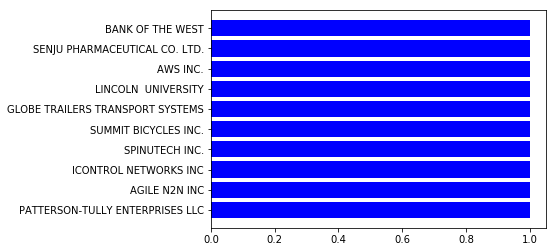

In [44]:
#Top 10 companies with denied status
barPlot(top_10_companies_by_status(h1b_data_frame, "DENIED"))
plt.show()

Here we look at the top 10 companies with most certified status.

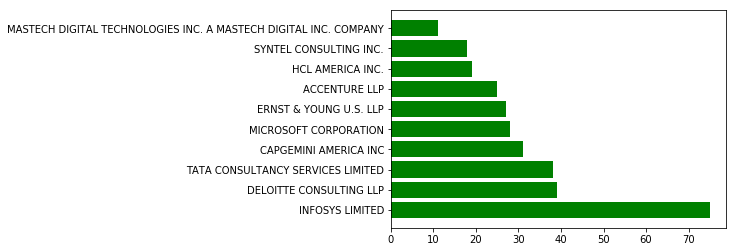

In [45]:
#Top 10 cmpanies with Certified status
barPlot(top_10_companies_by_status(h1b_data_frame, "CERTIFIED"),"Green")
plt.show()

#### 2. State-wise average prevailing wage
Here we take the average prevailing wage of all employees from each state.

In [33]:
prevailingwage_by_state = h1b_data_frame.map(lambda x :(x.EMPLOYER_STATE, (x.PREVAILING_WAGE, 1)))\
    .reduceByKey(lambda x, y : (x[0]+y[0], x[1]+y[1]))\
    .mapValues(lambda x : float(x[0])/float(x[1]))\
    .map(lambda x : (x[1],x[0]))
prevailingwage_by_state_sorted = prevailingwage_by_state.sortByKey(ascending=False)
prevailingwage_by_state_sorted_10 = prevailingwage_by_state_sorted.toDF().limit(10)

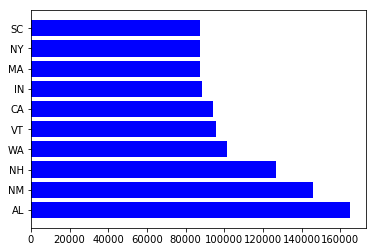

In [34]:
prevailingwage_by_state_sorted_10 = prevailingwage_by_state_sorted_10.map(lambda x : (x[1],x[0]))
barPlot(prevailingwage_by_state_sorted_10)
plt.show()

Interestingly CA is behind DC in avg wage for H-1B workers. What could be the reason? Can we come up with some plots and outline the probable reasons?? Insight!

#### 3. Year-wise status


In [48]:
def year_wise_status(h1b_data_frame, status):
    status_by_year = h1b_data_frame\
    .map(lambda x : (x.CASE_SUBMITTED, (1, 1 if x.CASE_STATUS == status else 0)))\
    .reduceByKey(lambda x, y : (x[0]+y[0], x[1]+y[1]))\
    .mapValues(lambda x : float(x[1])*100/float(x[0]))\
    .sortByKey()
    return status_by_year

Here we visualize year wise certified vs denied status. We print the percentages to see how the trend goes. Green corresponds to certified and red to denied.

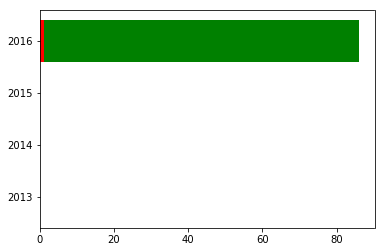

In [55]:
barPlot(year_wise_status(h1b_data_frame, "CERTIFIED"), "Green")
barPlot(year_wise_status(h1b_data_frame, "DENIED"), "Red")
plt.show()

#### 4. Shows count of each status.

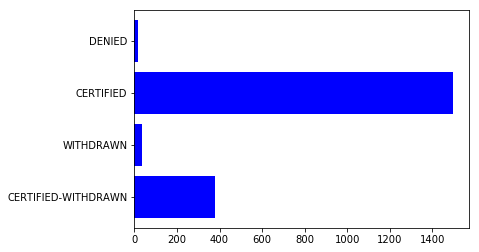

In [51]:
class_count = h1b_data_frame.map(lambda x : (x.CASE_STATUS, 1)).reduceByKey(lambda x, y : x+y)
barPlot(class_count)
plt.show()

#### Logistic Regression

In [27]:
model = LogisticRegressionWithLBFGS.train(h1b_labeled_points, numClasses=4)

#### Evaluate model on training data

In [28]:
real_predictions = h1b_labeled_points.map(lambda x : (x.label, model.predict(x.features)))

#### Accuracy based on number of correct predictions.

In [29]:
total = real_predictions.count()
trues = real_predictions.filter(lambda x : x[0]==x[1]).count()
accuracy = 100*float(trues)/float(total)
print(accuracy)

77.6970954357
